In [1]:
# --- KOMÓRKA 0: PODŁĄCZ DYSK GOOGLE ---
from google.colab import drive
drive.mount('/content/drive')
print("Dysk Google podłączony.")

Mounted at /content/drive
Dysk Google podłączony.


In [2]:
# --- KOMÓRKA 1: BIBLIOTEKI ---
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, median_absolute_error

# Biblioteki do sieci neuronowych (Keras/TensorFlow)
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping

# Ustawienia wykresów
plt.style.use('seaborn-v0_8-darkgrid')
print("Biblioteki załadowane pomyślnie (TensorFlow gotowy).")

Biblioteki załadowane pomyślnie (TensorFlow gotowy).


In [3]:
# --- KOMÓRKA 2: DANE I CECHY FIZYCZNE ---
# Wczytanie (dostosuj ścieżkę jeśli trzeba)
try:
    df = pd.read_csv('final_data.csv') # Lub ścieżka z Google Drive
except:
    # Fallback dla przykładu, jeśli plik nie istnieje w bieżącym katalogu
    path = '/content/drive/MyDrive/FF_MOTOR_PROJECT/data/final_data.csv'
    df = pd.read_csv(path)

if not df.empty:
    # 1. INTERAKCJA (Moment * Prędkość)
    df['inter_fr'] = df['setpoint_fr'] * df['speed_fr']
    df['inter_rl'] = df['setpoint_rl'] * df['speed_rl']
    df['inter_rr'] = df['setpoint_rr'] * df['speed_rr']

    # 2. STRATY CIEPLNE (Prąd^2 ~ Setpoint^2)
    df['heat_fr'] = df['setpoint_fr'] ** 2
    df['heat_rl'] = df['setpoint_rl'] ** 2
    df['heat_rr'] = df['setpoint_rr'] ** 2

    # 3. DYNAMIKA (Przyspieszenie i Średnie kroczące)
    # Dla sieci LSTM surowe dane są ok, ale te cechy pomagają jej szybciej się uczyć
    df['acc_fr'] = df['speed_fr'].diff().fillna(0)
    df['acc_rl'] = df['speed_rl'].diff().fillna(0)
    df['acc_rr'] = df['speed_rr'].diff().fillna(0)

    # Usuwamy NaN powstałe przy diff()
    df.dropna(inplace=True)

    print(f"Dane przygotowane: {df.shape}")

Dane przygotowane: (51802, 16)


In [4]:
# --- KOMÓRKA 3: PREPROCESSING DLA LSTM ---

# 1. Wybór cech (X) i celu (y)
features = [col for col in df.columns if col != 'power']
X_raw = df[features].values
y_raw = df['power'].values.reshape(-1, 1)

# 2. Skalowanie danych (LSTM wymaga zakresu 0-1 lub -1 do 1)
scaler_X = MinMaxScaler()
scaler_y = MinMaxScaler()

X_scaled = scaler_X.fit_transform(X_raw)
y_scaled = scaler_y.fit_transform(y_raw)

# 3. Tworzenie sekwencji (Sliding Window)
# TIME_STEPS = ile kroków wstecz widzi sieć (np. 20 próbek = historia z ostatnich ułamków sekund)
TIME_STEPS = 20

def create_sequences(X, y, time_steps):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        # Weź okno od i do i+steps
        Xs.append(X[i:(i + time_steps)])
        # Przewiduj wartość w kroku i+steps
        ys.append(y[i + time_steps])
    return np.array(Xs), np.array(ys)

print(f"Tworzenie sekwencji czasowych (okno = {TIME_STEPS})...")
X_seq, y_seq = create_sequences(X_scaled, y_scaled, TIME_STEPS)

# 4. Podział Chronologiczny (80% trening, 20% test)
train_size = int(len(X_seq) * 0.8)

X_train, X_test = X_seq[:train_size], X_seq[train_size:]
y_train, y_test = y_seq[:train_size], y_seq[train_size:]

print(f"Kształt danych treningowych (X): {X_train.shape}  <- (Próbki, Kroki Czasowe, Cechy)")
print(f"Kształt danych treningowych (y): {y_train.shape}")

Tworzenie sekwencji czasowych (okno = 20)...
Kształt danych treningowych (X): (41425, 20, 15)  <- (Próbki, Kroki Czasowe, Cechy)
Kształt danych treningowych (y): (41425, 1)


In [5]:
# --- KOMÓRKA 4: MODEL I TRENING ---

# Definicja modelu
model = Sequential()

# Warstwa 1: LSTM (zwraca sekwencje dla kolejnej warstwy LSTM)
# input_shape = (Kroki Czasowe, Liczba Cech)
model.add(Input(shape=(X_train.shape[1], X_train.shape[2])))
model.add(LSTM(units=64, return_sequences=True))
model.add(Dropout(0.2)) # Zapobiega przeuczeniu (wyłącza losowo 20% neuronów)

# Warstwa 2: LSTM (nie zwraca sekwencji, tylko wektor cech dla warstwy Dense)
model.add(LSTM(units=32, return_sequences=False))
model.add(Dropout(0.2))

# Warstwa 3: Gęsta (Wyjście - 1 wartość mocy)
model.add(Dense(units=1, activation='linear')) # Linear, bo przewidujemy wartość ciągłą

# Kompilacja
model.compile(optimizer=Adam(learning_rate=0.001), loss='mean_squared_error')

# Early Stopping - przerwij trening, jeśli model przestanie się uczyć
early_stop = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)

print("Rozpoczynam trening sieci LSTM...")
history = model.fit(
    X_train, y_train,
    epochs=30,           # Maksymalna liczba epok (dostosuj wg potrzeb)
    batch_size=64,       # Aktualizacja wag co 64 próbki
    validation_data=(X_test, y_test),
    callbacks=[early_stop],
    verbose=1
)
print("Trening zakończony.")

Rozpoczynam trening sieci LSTM...
Epoch 1/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 23s 30ms/step - loss: 0.0079 - val_loss: 3.7634e-04
Epoch 2/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.0018 - val_loss: 3.6379e-04
Epoch 3/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 21s 30ms/step - loss: 0.0014 - val_loss: 3.5026e-04
Epoch 4/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 0.0013 - val_loss: 3.6861e-04
Epoch 5/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 41s 31ms/step - loss: 0.0012 - val_loss: 3.4341e-04
Epoch 6/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - loss: 0.0012 - val_loss: 3.5373e-04
Epoch 7/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 0.0012 - val_loss: 4.4879e-04
Epoch 8/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - loss: 0.0011 - val_loss: 3.4421e-04
Epoch 9/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 19s 30ms/step - loss: 0.0011 - val_loss: 3.1976e-04
Epoch 10/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - loss: 0.0011 - val_loss: 3.3949e-04
Epoch 11/30
648/648 ━━━━━━━━━━━━━━━━━━━━ 20s 

Generowanie predykcji...
324/324 ━━━━━━━━━━━━━━━━━━━━ 2s 7ms/step

 WYNIKI MODELU LSTM
R2 Score: 0.9927
RMSE:     112987.59 W
MAE:      69706.73 W


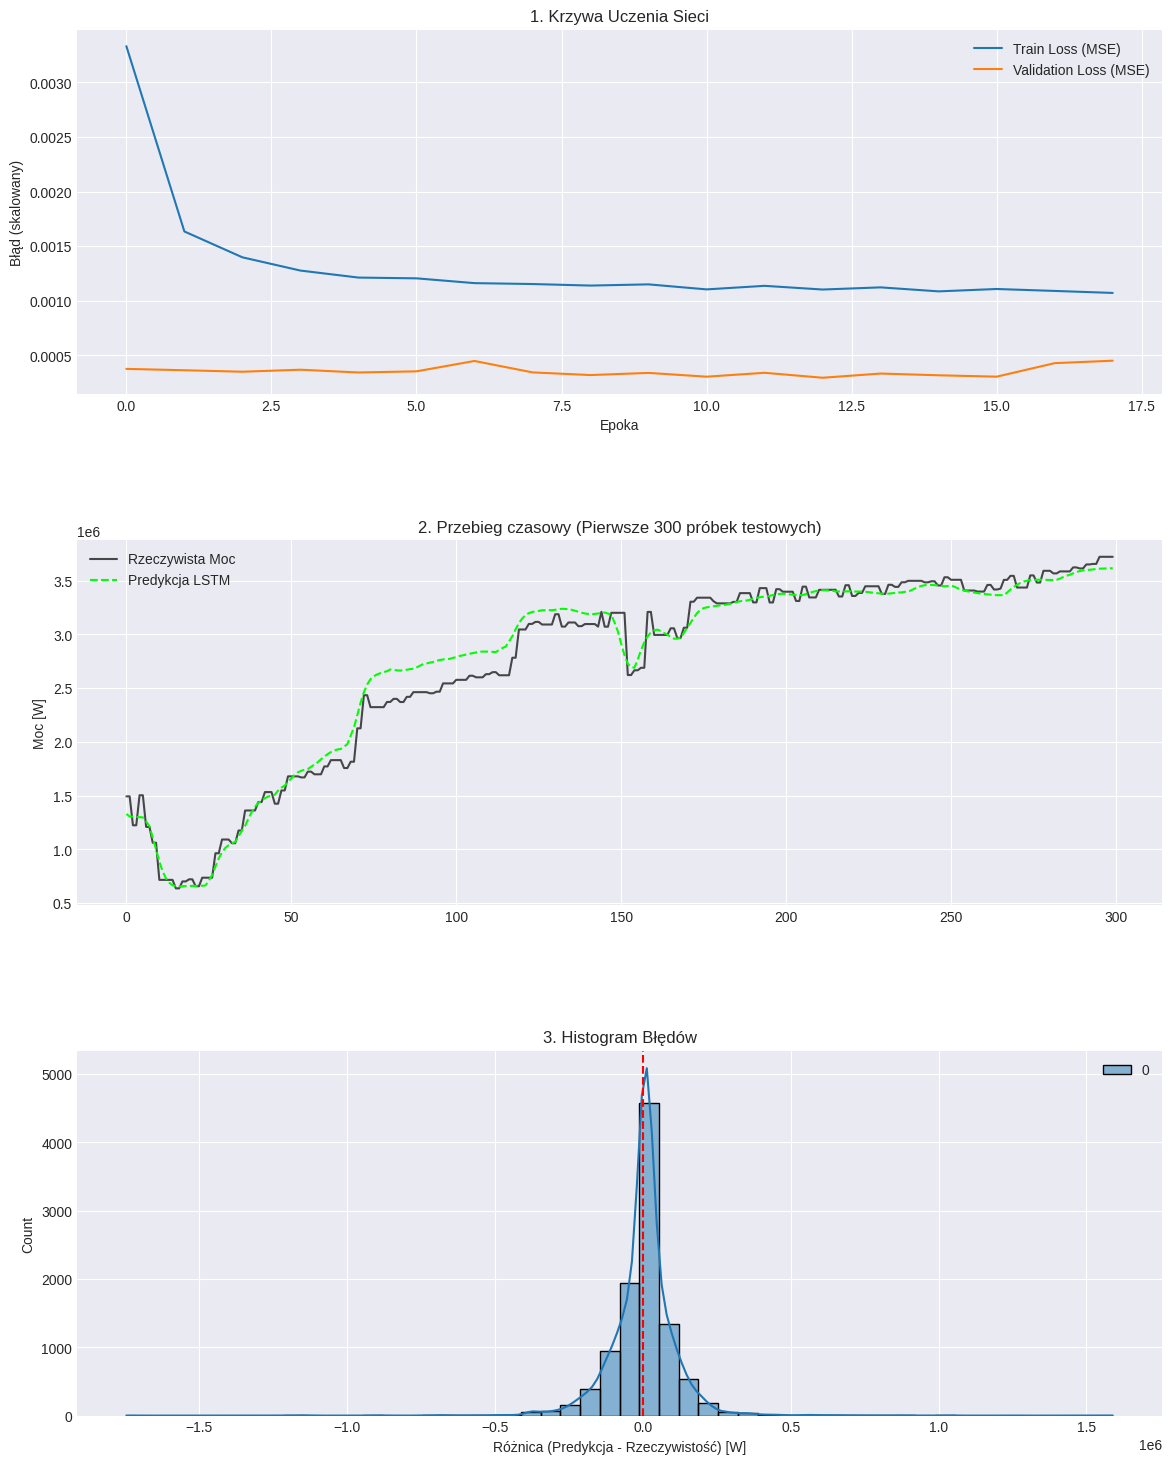

In [7]:
# --- KOMÓRKA 5: ANALIZA WYNIKÓW ---

# 1. Predykcja
print("Generowanie predykcji...")
y_pred_scaled = model.predict(X_test)

# 2. Odwrócenie skalowania (Powrót do Watów)
y_pred_real = scaler_y.inverse_transform(y_pred_scaled)
y_test_real = scaler_y.inverse_transform(y_test)

# 3. Obliczenie metryk
mae = mean_absolute_error(y_test_real, y_pred_real)
rmse = np.sqrt(mean_squared_error(y_test_real, y_pred_real))
r2 = r2_score(y_test_real, y_pred_real)

# Błędy rezydualne
residuals = y_test_real - y_pred_real

print("\n" + "="*40)
print(f" WYNIKI MODELU LSTM")
print("="*40)
print(f"R2 Score: {r2:.4f}")
print(f"RMSE:     {rmse:.2f} W")
print(f"MAE:      {mae:.2f} W")
print("="*40)

# --- WIZUALIZACJA ---
fig, axes = plt.subplots(3, 1, figsize=(14, 18))
plt.subplots_adjust(hspace=0.4)

# WYKRES 1: Krzywa Uczenia (Loss)
axes[0].plot(history.history['loss'], label='Train Loss (MSE)')
axes[0].plot(history.history['val_loss'], label='Validation Loss (MSE)')
axes[0].set_title('1. Krzywa Uczenia Sieci')
axes[0].set_xlabel('Epoka')
axes[0].set_ylabel('Błąd (skalowany)')
axes[0].legend()

# WYKRES 2: Rzeczywistość vs Predykcja (Zoom)
subset = 300
axes[1].plot(y_test_real[:subset], label='Rzeczywista Moc', color='black', alpha=0.7)
axes[1].plot(y_pred_real[:subset], label='Predykcja LSTM', color='lime', linestyle='--')
axes[1].set_title(f'2. Przebieg czasowy (Pierwsze {subset} próbek testowych)')
axes[1].set_ylabel('Moc [W]')
axes[1].legend()

# WYKRES 3: Rozkład Błędów
sns.histplot(residuals, bins=50, kde=True, ax=axes[2], color='purple')
axes[2].axvline(0, color='red', linestyle='--')
axes[2].set_title('3. Histogram Błędów')
axes[2].set_xlabel('Różnica (Predykcja - Rzeczywistość) [W]')

plt.show()